## Diffusive Shock Acceleration (DSA)

In DSA - or First Order Fermi Acceleration - charged particles experience energy gain when they (repeatedly) cross a moving shock front. At non-relativistic, stationary, ideal shocks, neglecting backreaction of particles to the background plasma, the energy spectrum is a power-law, only depending on the shocks compression ratio $q = u_{\mathrm{up}}/ u_{\mathrm{down}}$. For a strong shock with compression $q = 4$, the expected spectral slope is $-2$.

In the diffusive picture, DSA comes from adiabatic heating due to the changing advection field, $\nabla \vec{u} \neq 0$. An infinitly thin shock can not be modeled, instead the shock profile is smoothed, e.g. in 1D $u(x) \propto \mathrm{tanh}(x/L_{\mathrm{sh}})$. The shock width $L_{\mathrm{sh}}$ now implies constraints on the diffusion coefficient $\kappa$ and time step $\Delta t$ of the simulation: 

1. The (average) diffusive step $\sqrt{\kappa \Delta t}$ must be higher than the shock width $L_{\mathrm{sh}}$. 
   1. If diffusion is too small, (pseudo-)particles do not make it back over the shock and there is (almost) no acceleration
   2. If the shock width is too large compared to the diffusive step, a smooth velocity gradient is modeled instead of a real shock. This leads to steeper energy-spectra compared to the ideal shock
2. The advective step $\left(u + \partial \kappa(x)/\partial x \right)\Delta t$ must be smaller than the shock width $L_{\mathrm{sh}}$. 
   1. If advection is too high, the probability that pseudo-particles encounter the changing advection field is too low. With that acceleration is underestimated, leading to steeper spectra. 
   2. The drift term due to changing diffusion coefficients, pushes pseudo-particles away from the shock. Currently, CRPropa3.2 supports energy-dependent diffusion that is constant in space. Thus, the advective step is only determined by the advection speed and time step.


(This example is adapted directly from the one in the [CRPropa page](https://crpropa.github.io/CRPropa3/pages/example_notebooks/acceleration/diffusive_shock_acceleration.html)).

In [16]:
from crpropa import *

def simulate(v, nEvents = 1000, E0 = 1 * TeV, compression = 4., epsilon = 0., alpha = 0.5, kappa = 1.):
	"""
	"""
	particleId = 11
	sourcePosition = Vector3d(0., 0, 0)
	outputFile = 'sim/accelerationDSA.txt'

	velocityU = v
	shockSize = 0.02 
	shock = OneDimensionalCartesianShock(compression, velocityU, shockSize)
	adiabaticCooling = AdiabaticCooling(shock)

	# diffusion
	bField = UniformMagneticField(Vector3d(1e-13, 0, 0.))
	timeStep = 0.005

	minStep = timeStep * c_light
	maxStep = minStep
	precision = 0.001

	# the propagation mode; solve diffusion equation

	propagator = DiffusionSDE(bField, shock, precision, minStep, maxStep, epsilon)
	propagator.setAlpha(alpha)
	propagator.setScale(kappa / 6.1e24)


	# the "source" (= initial conditions)
	source = Source()
	source.add(SourceParticleType(particleId))
	source.add(SourcePosition(sourcePosition))
	source.add(SourceIsotropicEmission())
	source.add(SourceEnergy(E0))
	
	


	# output file
	output = TextOutput(outputFile, Output.Event1D)
	output.setEnergyScale(eV)
	output.setLengthScale(meter)
	output.enable(output.WeightColumn)
	output.enable(output.CurrentPositionColumn)

	# build a time-dependent observer (snapshots)
	tMin = timeStep
	tMax = 200. + timeStep
	nTime = int((tMax - tMin) / timeStep)
	observer = Observer()
	observer.add(ObserverTimeEvolution(tMin * c_light, tMax * c_light, nTime, False))
	observer.setDeactivateOnDetection(False)
	observer.onDetection(output)

	# candidate splitting (increase statistics at high energies)
	splittingSpecIndex = -2.  # expected spectral index
	splittingEmin = 10 * E0  # minimal energy for splitting
	splittingFactor = 5  # number of energy bins/maximal splitting
	splitting = CandidateSplitting(splittingSpecIndex, splittingEmin, splittingFactor)

	# stopping conditions
	maxTrajectory = MaximumTrajectoryLength(tMax * c_light)

	# the actual simulation
	m = ModuleList()
	m.add(propagator)
	m.add(adiabaticCooling)
	m.add(observer)
	m.add(maxTrajectory)
	m.add(splitting)
	m.setShowProgress(True)
	m.run(source, nEvents)

	output.close()


In [17]:
simulate(10., nEvents = 100)

crpropa::ModuleList: Number of Threads: 10
Run ModuleList
  Started Thu May 22 23:22:28 2025 : [ Finished ] 100%    Needed: 00:00:10  - Finished at Thu May 22 23:22:38 2025


In [12]:
import numpy as np
import pandas as pd


def readSimulation(filename):
	"""
	Read a simulation and return a pandas dataframe with the output, inferring the column names from the first line.
	"""
	with open(filename, 'r') as f:
		line = f.readline()
		line = line.replace('\n', '').replace('#', '')
		names = line.split('\t')[1:]	

	data = pd.read_csv(filename, delimiter = '\t', comment = '#', names = names)
	data['T'] = data['D'] / c_light
	return data

def computeSpectrum(df, columnName = 'W'):
	"""
	For a reweighted dataframe with an existing column named 'columnName', computes the spectrum.

	# Input
	. `df`: the dataframe \\
	. `columnName`: the name of the column from where the weights will be taken \\
	"""
	bins = np.logspace(12, 18, 24)
	y, edges = np.histogram(df['E'], bins = bins, weights = df[columnName])
	x = edges[:-1] + ((edges[1:] - edges[:-1]) / 2.)
	y /= np.diff(edges)
	y *= (x ** 2) # for E^2 dN/dE
	y /= np.amax(y)

	return x, y


def computeNumberDensity(df, columnName = 'W'):
	"""
	For a reweighted dataframe with an existing column named 'columnName', computes the spectrum.

	# Input
	. `df`: the dataframe \\
	. `columnName`: the name of the column from where the weights will be taken \\
	"""
	bins = np.linspace(-10., 90., 100)
	y, edges = np.histogram(df['X'], bins = bins, weights = df[columnName])
	x = edges[:-1] + ((edges[1:] - edges[:-1]) / 2.)
	y /= np.diff(edges)
	y *= (x ** 2) # for E^2 dN/dE
	y /= np.amax(y)

	return x, y

In [18]:
data = readSimulation('sim/accelerationDSA.txt')

### Burst

Pseudo-particles are injected at the shock at $t=0$ and propagated until the maximum simulation time.
We plot the energy-spectrum at the shock and number density (integrated over energy) in the acceleration region over time

/var/folders/0y/t3vm35v95yb3yyp1j_09rs280000gn/T/ipykernel_11673/2591305349.py:31: RuntimeWarning: invalid value encountered in divide
  y /= np.amax(y)
/var/folders/0y/t3vm35v95yb3yyp1j_09rs280000gn/T/ipykernel_11673/2591305349.py:49: RuntimeWarning: invalid value encountered in divide
  y /= np.amax(y)


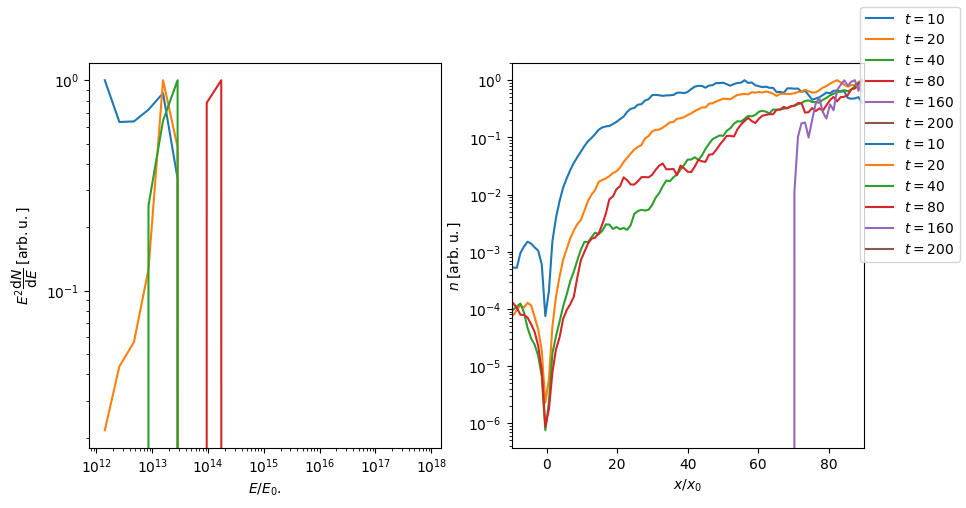

In [20]:
import matplotlib.pyplot as plt

times = [10, 20, 40, 80, 160, 200]
dt = 10

fig, ax = plt.subplots(1, 2, figsize = (10, 5))

for i in range(len(times)):
	# energy spectrum at the shock; separate by time
	idx = (data['X'] > 0) & (data['X'] < 2) & (data['T'] > times[i] - dt) & (data['T'] < times[i] + dt)
	energies, spectrum = computeSpectrum(data.loc[idx], columnName = 'W')

	# number-density (integrated over energy)
	idx = (data['T'] > times[i] - dt) & (data['T'] < times[i] + dt)
	distances, distDistribution = computeNumberDensity(data.loc[idx], columnName = 'W')

	ax[0].plot(energies, spectrum, label = r'$t = %i$' %times[i])
	ax[1].plot(distances, distDistribution, label = r'$t = %i$' %times[i])

ax[0].set_xscale('log')
ax[0].set_yscale('log')
ax[0].set_xlabel("$E / E_0$.")
ax[0].set_ylabel("$ E^2 \\dfrac{\\mathrm{d}N}{\\mathrm{d}E} \\; \\mathrm{[arb. u.]}$")

ax[1].set_xlim(-10, 90)
ax[1].set_yscale('log')
ax[1].set_xlabel("$x / x_0$")
ax[1].set_ylabel('$n \\; \\mathrm{[arb. u.]}$')

fig.legend()
